<a href="https://colab.research.google.com/github/faruk56-arch/sentiment-analysis_machine_learning/blob/master/last_updated_UNet%2B%2B_correct_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install -r /content/drive/MyDrive/Medical_Image_Segmentation/modular_code/source/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 54.6 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.4.2-cp310-cp310-linux_x86_64.whl size=10437844 sha256=64015df63fa0d7c5ce4703b0ae197c02e101ff190d0be24ddbf3fb50b4c0d58c
  Stored in directory: /root/.cache/pip/wheels/d9/e8/73/f806fc

In [3]:
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from collections import OrderedDict
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf

# from train import train, validate
# from source.network import UNetPP
# from source.dataset import DataSet

In [4]:
import os
import cv2
import numpy as np
import torch.utils.data


class DataSet(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))

        mask = []
        mask.append(cv2.imread(os.path.join(self.mask_dir,
                                            img_id + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        return img, mask, {'img_id': img_id}



In [5]:
import torch
from torch import nn


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNetPP(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output


In [6]:
import torch


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


In [7]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
# from source.utils import iou_score, AverageMeter
from albumentations import Resize
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf
from albumentations import RandomRotate90
# from source.network import UNetPP
# from source.dataset import DataSet


def train(deep_sup, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for input, target, _ in train_loader:
        input = input.to(device)
        target = target.to(device)

        # compute output
        if deep_sup:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_sup, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            input = input.to(device)
            target = target.to(device)

            # compute output
            if deep_sup:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


In [8]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

# from source.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose
from albumentations import Resize


val_transform = Compose([
    transforms.Resize(256, 256),
    transforms.Normalize(),
])


def image_loader(image_name):
    img = cv2.imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)

    return img

In [9]:
configOne = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/source/config.yaml"


In [10]:
with open(configOne) as f:
    config = yaml.load(f,Loader=yaml.Loader)

extn = config["extn"]
epochs = config["epochs"]
log_path = config["log_path"]
mask_path = config["mask_path"]
image_path = config["image_path"]
model_path = config["model_path"]

## Create log file

In [11]:
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0

## Split images into train and validation set

In [12]:
extn_ = f"*{extn}"
img_ids = glob(os.path.join(image_path, extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.1)

## Define data transformations

In [13]:
train_transform = Compose([
    transforms.RandomRotate90(),
    transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightness(),
        transforms.RandomContrast(),
    ], p=1),
    transforms.Resize(256, 256),
    transforms.Normalize(),
])

val_transform = Compose([
    transforms.Resize(256, 256),
    transforms.Normalize(),
])

## Create train and validation dataset

In [14]:
train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform)

## Create train and validation data loaders

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False)

## Create the model object

In [16]:
# Create model object
model = UNetPP(1, 3, True)

# Port model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()


# Define Loss Function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())

# Define Optimizer
optimizer = optim.Adam(params, lr=1e-2, weight_decay=1e-4)

In [17]:
model_path= "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/models/model.pth"
log_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/models/logs/logs.csv"
image_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Original"
mask_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Ground Truth"
output_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/prediction.png"


In [18]:
# # Load the model before starting the training loop
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode if not training
    print("Model loaded successfully from", model_path)
else:
    print("No pre-trained model found, proceeding with training from scratch.")

Model loaded successfully from /content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/models/model.pth


## Run the train loop

In [16]:
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')

    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [0/300]


100%|██████████| 8/8 [01:37<00:00, 12.21s/it, loss=0.45, iou=1.13e-10]


loss 0.4578 - iou 0.0376 - val_loss 0.4496 - val_iou 0.0000


  0%|          | 0/30 [00:00<?, ?it/s]

=> saved best model
Epoch [1/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.3527 - iou 0.0023 - val_loss 0.3254 - val_iou 0.0000
Epoch [2/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.3050 - iou 0.0005 - val_loss 0.3330 - val_iou 0.0000
Epoch [3/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2778 - iou 0.0001 - val_loss 0.3064 - val_iou 0.0000
Epoch [4/300]


100%|██████████| 8/8 [00:04<00:00,  1.77it/s, loss=0.463, iou=0.0733]


loss 0.2663 - iou 0.0000 - val_loss 0.4630 - val_iou 0.0733


  0%|          | 0/30 [00:00<?, ?it/s]

=> saved best model
Epoch [5/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2586 - iou 0.0018 - val_loss 0.3071 - val_iou 0.0047
Epoch [6/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2487 - iou 0.0260 - val_loss 0.2949 - val_iou 0.0112
Epoch [7/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2493 - iou 0.0230 - val_loss 0.2601 - val_iou 0.0007
Epoch [8/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2420 - iou 0.0651 - val_loss 0.2380 - val_iou 0.0000
Epoch [9/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2418 - iou 0.0096 - val_loss 0.2586 - val_iou 0.0013
Epoch [10/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2404 - iou 0.0211 - val_loss 0.2549 - val_iou 0.0906
=> saved best model
Epoch [11/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2361 - iou 0.0892 - val_loss 0.2547 - val_iou 0.1813
=> saved best model
Epoch [12/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2382 - iou 0.1070 - val_loss 0.2313 - val_iou 0.0117
Epoch [13/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2309 - iou 0.1356 - val_loss 0.2391 - val_iou 0.0000
Epoch [14/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2299 - iou 0.1488 - val_loss 0.2852 - val_iou 0.1805
Epoch [15/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2308 - iou 0.1305 - val_loss 0.2288 - val_iou 0.0000
Epoch [16/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2291 - iou 0.1990 - val_loss 0.2392 - val_iou 0.0513
Epoch [17/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2246 - iou 0.2066 - val_loss 0.2566 - val_iou 0.0001
Epoch [18/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2283 - iou 0.1813 - val_loss 0.2104 - val_iou 0.0988
Epoch [19/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2237 - iou 0.1978 - val_loss 0.2513 - val_iou 0.0054
Epoch [20/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2241 - iou 0.2058 - val_loss 0.3247 - val_iou 0.0032
Epoch [21/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2177 - iou 0.2357 - val_loss 0.2204 - val_iou 0.2475
=> saved best model
Epoch [22/300]


100%|██████████| 8/8 [00:04<00:00,  1.76it/s, loss=0.277, iou=0.261]


loss 0.2226 - iou 0.2178 - val_loss 0.2772 - val_iou 0.2613


  0%|          | 0/30 [00:00<?, ?it/s]

=> saved best model
Epoch [23/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2199 - iou 0.2569 - val_loss 0.2351 - val_iou 0.2209
Epoch [24/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2180 - iou 0.2549 - val_loss 0.3990 - val_iou 0.1663
Epoch [25/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2180 - iou 0.2807 - val_loss 0.4141 - val_iou 0.1849
Epoch [26/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2111 - iou 0.2918 - val_loss 0.2561 - val_iou 0.0000
Epoch [27/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2107 - iou 0.2914 - val_loss 0.4205 - val_iou 0.1982
Epoch [28/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2094 - iou 0.2970 - val_loss 0.2656 - val_iou 0.1545
Epoch [29/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2094 - iou 0.2975 - val_loss 0.2706 - val_iou 0.2894
=> saved best model
Epoch [30/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2069 - iou 0.3295 - val_loss 0.2049 - val_iou 0.1233
Epoch [31/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2108 - iou 0.2991 - val_loss 0.2464 - val_iou 0.0491
Epoch [32/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2099 - iou 0.2922 - val_loss 0.2588 - val_iou 0.0000
Epoch [33/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2071 - iou 0.3461 - val_loss 0.2383 - val_iou 0.3599
=> saved best model
Epoch [34/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2020 - iou 0.3532 - val_loss 0.2886 - val_iou 0.0000
Epoch [35/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2066 - iou 0.3258 - val_loss 0.2287 - val_iou 0.0981
Epoch [36/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1995 - iou 0.3692 - val_loss 0.2638 - val_iou 0.0862
Epoch [37/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2009 - iou 0.3517 - val_loss 0.3249 - val_iou 0.3240
Epoch [38/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1971 - iou 0.3701 - val_loss 0.2211 - val_iou 0.2455
Epoch [39/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1978 - iou 0.3560 - val_loss 0.2683 - val_iou 0.0000
Epoch [40/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2010 - iou 0.3594 - val_loss 0.2332 - val_iou 0.3174
Epoch [41/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1931 - iou 0.4037 - val_loss 0.7649 - val_iou 0.1748
Epoch [42/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1920 - iou 0.4056 - val_loss 0.3646 - val_iou 0.1926
Epoch [43/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1978 - iou 0.3633 - val_loss 0.2326 - val_iou 0.1383
Epoch [44/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1927 - iou 0.4100 - val_loss 0.2835 - val_iou 0.0000
Epoch [45/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1900 - iou 0.4028 - val_loss 0.2402 - val_iou 0.2032
Epoch [46/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1893 - iou 0.4233 - val_loss 0.2692 - val_iou 0.0000
Epoch [47/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1908 - iou 0.4176 - val_loss 0.4392 - val_iou 0.2328
Epoch [48/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1856 - iou 0.4430 - val_loss 0.2633 - val_iou 0.0056
Epoch [49/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1887 - iou 0.4456 - val_loss 0.2952 - val_iou 0.0050
Epoch [50/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1872 - iou 0.4190 - val_loss 0.2384 - val_iou 0.1459
Epoch [51/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1857 - iou 0.4315 - val_loss 0.3315 - val_iou 0.1620
Epoch [52/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1864 - iou 0.4537 - val_loss 0.2105 - val_iou 0.1477
Epoch [53/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1808 - iou 0.4709 - val_loss 0.2857 - val_iou 0.0000
Epoch [54/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1804 - iou 0.4727 - val_loss 0.2664 - val_iou 0.0000
Epoch [55/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1761 - iou 0.4929 - val_loss 0.4591 - val_iou 0.2353
Epoch [56/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1727 - iou 0.5023 - val_loss 0.2943 - val_iou 0.0007
Epoch [57/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1805 - iou 0.4982 - val_loss 0.2503 - val_iou 0.1500
Epoch [58/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1767 - iou 0.4939 - val_loss 0.2925 - val_iou 0.0000
Epoch [59/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1752 - iou 0.4965 - val_loss 0.3587 - val_iou 0.0004
Epoch [60/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1699 - iou 0.5467 - val_loss 0.2948 - val_iou 0.0000
Epoch [61/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1686 - iou 0.5391 - val_loss 0.2667 - val_iou 0.0000
Epoch [62/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1704 - iou 0.5251 - val_loss 0.3178 - val_iou 0.0000
Epoch [63/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1644 - iou 0.5678 - val_loss 0.3917 - val_iou 0.2111
Epoch [64/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1675 - iou 0.5503 - val_loss 0.2627 - val_iou 0.0870
Epoch [65/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1631 - iou 0.5684 - val_loss 0.2645 - val_iou 0.1157
Epoch [66/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1681 - iou 0.5328 - val_loss 0.3246 - val_iou 0.2652
Epoch [67/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1709 - iou 0.5441 - val_loss 0.2261 - val_iou 0.1558
Epoch [68/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1618 - iou 0.5765 - val_loss 0.3277 - val_iou 0.0000
Epoch [69/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1597 - iou 0.5888 - val_loss 0.2807 - val_iou 0.0000
Epoch [70/300]


100%|██████████| 8/8 [00:04<00:00,  1.82it/s, loss=0.183, iou=0.414]


loss 0.1681 - iou 0.5675 - val_loss 0.1833 - val_iou 0.4138


  0%|          | 0/30 [00:00<?, ?it/s]

=> saved best model
Epoch [71/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1644 - iou 0.5771 - val_loss 0.3523 - val_iou 0.0000
Epoch [72/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1590 - iou 0.5903 - val_loss 0.3520 - val_iou 0.0010
Epoch [73/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1537 - iou 0.6140 - val_loss 0.3494 - val_iou 0.0784
Epoch [74/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1522 - iou 0.6250 - val_loss 0.1952 - val_iou 0.3079
Epoch [75/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1573 - iou 0.6054 - val_loss 0.4839 - val_iou 0.2020
Epoch [76/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1571 - iou 0.5909 - val_loss 0.3612 - val_iou 0.0000
Epoch [77/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1592 - iou 0.5956 - val_loss 0.1787 - val_iou 0.4767
=> saved best model
Epoch [78/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1518 - iou 0.6209 - val_loss 0.3050 - val_iou 0.0000
Epoch [79/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1527 - iou 0.6236 - val_loss 0.2920 - val_iou 0.0006
Epoch [80/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1542 - iou 0.6167 - val_loss 0.2896 - val_iou 0.1655
Epoch [81/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1559 - iou 0.6092 - val_loss 0.2786 - val_iou 0.0000
Epoch [82/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1525 - iou 0.6183 - val_loss 0.3242 - val_iou 0.0000
Epoch [83/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1539 - iou 0.6347 - val_loss 0.1910 - val_iou 0.3779
Epoch [84/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1549 - iou 0.6227 - val_loss 0.3418 - val_iou 0.0000
Epoch [85/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1522 - iou 0.6504 - val_loss 0.2017 - val_iou 0.3772
Epoch [86/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1518 - iou 0.6403 - val_loss 0.3592 - val_iou 0.0072
Epoch [87/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1490 - iou 0.6371 - val_loss 0.3171 - val_iou 0.0000
Epoch [88/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1477 - iou 0.6539 - val_loss 0.2794 - val_iou 0.0883
Epoch [89/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1466 - iou 0.6597 - val_loss 0.2912 - val_iou 0.0003
Epoch [90/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1441 - iou 0.6732 - val_loss 0.2668 - val_iou 0.1261
Epoch [91/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1462 - iou 0.6627 - val_loss 0.2135 - val_iou 0.3626
Epoch [92/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1451 - iou 0.6609 - val_loss 0.3343 - val_iou 0.0000
Epoch [93/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1469 - iou 0.6663 - val_loss 0.3397 - val_iou 0.0000
Epoch [94/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1437 - iou 0.6696 - val_loss 0.3315 - val_iou 0.2485
Epoch [95/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1448 - iou 0.6718 - val_loss 0.4038 - val_iou 0.0000
Epoch [96/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1419 - iou 0.6734 - val_loss 0.2503 - val_iou 0.3153
Epoch [97/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1415 - iou 0.6768 - val_loss 0.2219 - val_iou 0.3476
Epoch [98/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1445 - iou 0.6778 - val_loss 0.2920 - val_iou 0.1385
Epoch [99/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1428 - iou 0.6731 - val_loss 0.3507 - val_iou 0.0000
Epoch [100/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1380 - iou 0.6855 - val_loss 0.3916 - val_iou 0.0000
Epoch [101/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1345 - iou 0.7235 - val_loss 0.3042 - val_iou 0.0175
Epoch [102/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1350 - iou 0.7167 - val_loss 0.3063 - val_iou 0.0426
Epoch [103/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1376 - iou 0.7157 - val_loss 0.2912 - val_iou 0.2277
Epoch [104/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1369 - iou 0.7016 - val_loss 0.2538 - val_iou 0.1156
Epoch [105/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1385 - iou 0.6948 - val_loss 0.3220 - val_iou 0.2177
Epoch [106/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1337 - iou 0.7180 - val_loss 0.2362 - val_iou 0.3917
Epoch [107/300]


100%|██████████| 8/8 [00:04<00:00,  1.78it/s, loss=0.168, iou=0.565]


loss 0.1387 - iou 0.6897 - val_loss 0.1681 - val_iou 0.5646


  0%|          | 0/30 [00:00<?, ?it/s]

=> saved best model
Epoch [108/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1350 - iou 0.7162 - val_loss 0.2460 - val_iou 0.2007
Epoch [109/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1369 - iou 0.7076 - val_loss 0.2882 - val_iou 0.0001
Epoch [110/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1414 - iou 0.7006 - val_loss 0.2115 - val_iou 0.5869
=> saved best model
Epoch [111/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1356 - iou 0.7230 - val_loss 0.2706 - val_iou 0.1667
Epoch [112/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1314 - iou 0.7400 - val_loss 0.2630 - val_iou 0.1524
Epoch [113/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1281 - iou 0.7329 - val_loss 0.3906 - val_iou 0.1301
Epoch [114/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1359 - iou 0.7140 - val_loss 0.3290 - val_iou 0.0001
Epoch [115/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1279 - iou 0.7500 - val_loss 0.2382 - val_iou 0.2198
Epoch [116/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1398 - iou 0.7012 - val_loss 0.2295 - val_iou 0.1746
Epoch [117/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1345 - iou 0.7189 - val_loss 0.1781 - val_iou 0.5578
Epoch [118/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1292 - iou 0.7363 - val_loss 0.3056 - val_iou 0.0592
Epoch [119/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1348 - iou 0.7147 - val_loss 0.4126 - val_iou 0.0041
Epoch [120/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1327 - iou 0.7314 - val_loss 0.3013 - val_iou 0.0381
Epoch [121/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1255 - iou 0.7541 - val_loss 0.2280 - val_iou 0.1823
Epoch [122/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1277 - iou 0.7481 - val_loss 0.3327 - val_iou 0.0544
Epoch [123/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1300 - iou 0.7375 - val_loss 0.3053 - val_iou 0.0000
Epoch [124/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1315 - iou 0.7413 - val_loss 0.4381 - val_iou 0.0000
Epoch [125/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1264 - iou 0.7480 - val_loss 0.2973 - val_iou 0.0426
Epoch [126/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1316 - iou 0.7384 - val_loss 0.2050 - val_iou 0.3626
Epoch [127/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1291 - iou 0.7377 - val_loss 0.2499 - val_iou 0.3676
Epoch [128/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1256 - iou 0.7620 - val_loss 0.3793 - val_iou 0.0000
Epoch [129/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1311 - iou 0.7351 - val_loss 0.2079 - val_iou 0.4150
Epoch [130/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1279 - iou 0.7429 - val_loss 0.3347 - val_iou 0.0000
Epoch [131/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1234 - iou 0.7734 - val_loss 0.1743 - val_iou 0.5182
Epoch [132/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1231 - iou 0.7644 - val_loss 0.2980 - val_iou 0.0191
Epoch [133/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1267 - iou 0.7594 - val_loss 0.2812 - val_iou 0.0557
Epoch [134/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1285 - iou 0.7423 - val_loss 0.2576 - val_iou 0.3183
Epoch [135/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1249 - iou 0.7628 - val_loss 0.3021 - val_iou 0.1039
Epoch [136/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1222 - iou 0.7669 - val_loss 0.1602 - val_iou 0.5897
=> saved best model
Epoch [137/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1294 - iou 0.7496 - val_loss 0.2182 - val_iou 0.3676
Epoch [138/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1231 - iou 0.7777 - val_loss 0.2334 - val_iou 0.3846
Epoch [139/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1162 - iou 0.7917 - val_loss 0.3498 - val_iou 0.0000
Epoch [140/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1213 - iou 0.7764 - val_loss 0.2852 - val_iou 0.1315
Epoch [141/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1239 - iou 0.7647 - val_loss 0.2205 - val_iou 0.4601
Epoch [142/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1211 - iou 0.7837 - val_loss 0.2625 - val_iou 0.3187
Epoch [143/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1215 - iou 0.7797 - val_loss 0.2767 - val_iou 0.0411
Epoch [144/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1219 - iou 0.7594 - val_loss 0.3218 - val_iou 0.0358
Epoch [145/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1203 - iou 0.7784 - val_loss 0.5103 - val_iou 0.3574
Epoch [146/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1200 - iou 0.7818 - val_loss 0.3267 - val_iou 0.0002
Epoch [147/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1254 - iou 0.7420 - val_loss 0.3642 - val_iou 0.2053
Epoch [148/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1184 - iou 0.7767 - val_loss 0.2381 - val_iou 0.2954
Epoch [149/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1228 - iou 0.7715 - val_loss 0.1681 - val_iou 0.5579
Epoch [150/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1189 - iou 0.7911 - val_loss 0.5045 - val_iou 0.3133
Epoch [151/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1236 - iou 0.7539 - val_loss 0.4625 - val_iou 0.0000
Epoch [152/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1168 - iou 0.7964 - val_loss 0.2111 - val_iou 0.3987
Epoch [153/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1245 - iou 0.7762 - val_loss 0.4572 - val_iou 0.1380
Epoch [154/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1196 - iou 0.7845 - val_loss 0.3750 - val_iou 0.3524
Epoch [155/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1175 - iou 0.7938 - val_loss 0.3897 - val_iou 0.0000
Epoch [156/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1180 - iou 0.7773 - val_loss 0.3293 - val_iou 0.0015
Epoch [157/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1226 - iou 0.7678 - val_loss 0.3902 - val_iou 0.0148
Epoch [158/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1155 - iou 0.7891 - val_loss 0.2421 - val_iou 0.4634
Epoch [159/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1180 - iou 0.7793 - val_loss 0.3482 - val_iou 0.0153
Epoch [160/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1206 - iou 0.7817 - val_loss 0.2751 - val_iou 0.0029
Epoch [161/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1133 - iou 0.8140 - val_loss 0.1592 - val_iou 0.6734
=> saved best model
Epoch [162/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1117 - iou 0.8066 - val_loss 0.3439 - val_iou 0.1273
Epoch [163/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1183 - iou 0.7825 - val_loss 0.2996 - val_iou 0.0377
Epoch [164/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1210 - iou 0.7722 - val_loss 0.2525 - val_iou 0.1549
Epoch [165/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1209 - iou 0.7895 - val_loss 0.2300 - val_iou 0.3033
Epoch [166/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1214 - iou 0.7812 - val_loss 0.3128 - val_iou 0.0196
Epoch [167/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1160 - iou 0.7984 - val_loss 0.2407 - val_iou 0.2302
Epoch [168/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1165 - iou 0.7998 - val_loss 0.2663 - val_iou 0.2301
Epoch [169/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1146 - iou 0.7970 - val_loss 0.3053 - val_iou 0.0132
Epoch [170/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1127 - iou 0.8017 - val_loss 0.4355 - val_iou 0.0000
Epoch [171/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1168 - iou 0.7940 - val_loss 0.6891 - val_iou 0.1700
Epoch [172/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1169 - iou 0.7897 - val_loss 0.3352 - val_iou 0.0294
Epoch [173/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1177 - iou 0.7840 - val_loss 0.4742 - val_iou 0.2277
Epoch [174/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1165 - iou 0.8026 - val_loss 0.2503 - val_iou 0.2643
Epoch [175/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1129 - iou 0.7996 - val_loss 0.2526 - val_iou 0.2399
Epoch [176/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1112 - iou 0.8213 - val_loss 0.3123 - val_iou 0.0898
Epoch [177/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1152 - iou 0.8048 - val_loss 0.3351 - val_iou 0.1103
Epoch [178/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1148 - iou 0.8069 - val_loss 0.1849 - val_iou 0.4838
Epoch [179/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1177 - iou 0.7902 - val_loss 0.9620 - val_iou 0.1933
Epoch [180/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1186 - iou 0.7836 - val_loss 0.2606 - val_iou 0.0940
Epoch [181/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1140 - iou 0.8062 - val_loss 0.3423 - val_iou 0.0234
Epoch [182/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1077 - iou 0.8279 - val_loss 0.3222 - val_iou 0.0756
Epoch [183/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1124 - iou 0.8089 - val_loss 0.3394 - val_iou 0.0232
Epoch [184/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1128 - iou 0.8092 - val_loss 0.3274 - val_iou 0.0126
Epoch [185/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1175 - iou 0.7863 - val_loss 0.2882 - val_iou 0.0017
Epoch [186/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1134 - iou 0.8013 - val_loss 0.2791 - val_iou 0.1412
Epoch [187/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1151 - iou 0.8075 - val_loss 0.2796 - val_iou 0.0374
Epoch [188/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1126 - iou 0.8173 - val_loss 0.4823 - val_iou 0.0000
Epoch [189/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1152 - iou 0.7983 - val_loss 0.4055 - val_iou 0.0000
Epoch [190/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1151 - iou 0.8052 - val_loss 0.4276 - val_iou 0.0000
Epoch [191/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1149 - iou 0.8104 - val_loss 0.3602 - val_iou 0.0062
Epoch [192/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1108 - iou 0.8071 - val_loss 0.5597 - val_iou 0.0808
Epoch [193/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1100 - iou 0.8137 - val_loss 0.2020 - val_iou 0.4397
Epoch [194/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1097 - iou 0.8259 - val_loss 0.1841 - val_iou 0.5917
Epoch [195/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1106 - iou 0.8066 - val_loss 0.2268 - val_iou 0.4180
Epoch [196/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1134 - iou 0.7989 - val_loss 0.3500 - val_iou 0.0097
Epoch [197/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1153 - iou 0.8022 - val_loss 0.2163 - val_iou 0.4265
Epoch [198/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1110 - iou 0.8121 - val_loss 0.4015 - val_iou 0.0000
Epoch [199/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1149 - iou 0.8011 - val_loss 0.1981 - val_iou 0.4262
Epoch [200/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1091 - iou 0.8252 - val_loss 0.3550 - val_iou 0.0033
Epoch [201/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1080 - iou 0.8233 - val_loss 0.1913 - val_iou 0.5541
Epoch [202/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1093 - iou 0.8249 - val_loss 0.3132 - val_iou 0.1016
Epoch [203/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1163 - iou 0.8011 - val_loss 0.4002 - val_iou 0.0014
Epoch [204/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1142 - iou 0.8125 - val_loss 0.2778 - val_iou 0.2118
Epoch [205/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1167 - iou 0.7986 - val_loss 0.4453 - val_iou 0.0026
Epoch [206/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1071 - iou 0.8304 - val_loss 0.2137 - val_iou 0.4953
Epoch [207/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1134 - iou 0.8173 - val_loss 0.1990 - val_iou 0.4263
Epoch [208/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8301 - val_loss 0.4071 - val_iou 0.0009
Epoch [209/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1069 - iou 0.8262 - val_loss 0.3230 - val_iou 0.0868
Epoch [210/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1096 - iou 0.8123 - val_loss 0.2804 - val_iou 0.0863
Epoch [211/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1099 - iou 0.8184 - val_loss 0.3736 - val_iou 0.0004
Epoch [212/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1051 - iou 0.8403 - val_loss 0.2516 - val_iou 0.3410
Epoch [213/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1074 - iou 0.8370 - val_loss 0.2851 - val_iou 0.0869
Epoch [214/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1125 - iou 0.8183 - val_loss 0.3116 - val_iou 0.1819
Epoch [215/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1134 - iou 0.8096 - val_loss 0.1908 - val_iou 0.4162
Epoch [216/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1087 - iou 0.8231 - val_loss 0.3204 - val_iou 0.0990
Epoch [217/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1031 - iou 0.8481 - val_loss 0.3367 - val_iou 0.0388
Epoch [218/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8377 - val_loss 0.1992 - val_iou 0.4722
Epoch [219/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1144 - iou 0.7989 - val_loss 0.2824 - val_iou 0.0075
Epoch [220/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1109 - iou 0.8168 - val_loss 0.2507 - val_iou 0.4626
Epoch [221/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1084 - iou 0.8249 - val_loss 0.1790 - val_iou 0.5609
Epoch [222/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1120 - iou 0.8120 - val_loss 0.2568 - val_iou 0.2520
Epoch [223/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1104 - iou 0.8224 - val_loss 0.3606 - val_iou 0.0000
Epoch [224/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8347 - val_loss 0.3593 - val_iou 0.0055
Epoch [225/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1070 - iou 0.8319 - val_loss 0.3085 - val_iou 0.0009
Epoch [226/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1101 - iou 0.8259 - val_loss 0.4453 - val_iou 0.1818
Epoch [227/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1047 - iou 0.8485 - val_loss 0.2558 - val_iou 0.2671
Epoch [228/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1034 - iou 0.8476 - val_loss 0.3162 - val_iou 0.1115
Epoch [229/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1060 - iou 0.8452 - val_loss 0.2765 - val_iou 0.2600
Epoch [230/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1149 - iou 0.7950 - val_loss 0.4109 - val_iou 0.0000
Epoch [231/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1122 - iou 0.8126 - val_loss 0.2999 - val_iou 0.1071
Epoch [232/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1065 - iou 0.8212 - val_loss 0.2124 - val_iou 0.5477
Epoch [233/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1076 - iou 0.8355 - val_loss 0.3388 - val_iou 0.0293
Epoch [234/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1076 - iou 0.8156 - val_loss 0.1812 - val_iou 0.5069
Epoch [235/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1087 - iou 0.8219 - val_loss 0.3687 - val_iou 0.5256
Epoch [236/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1040 - iou 0.8403 - val_loss 0.2324 - val_iou 0.2609
Epoch [237/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1117 - iou 0.8119 - val_loss 0.2208 - val_iou 0.4426
Epoch [238/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1114 - iou 0.8171 - val_loss 0.3204 - val_iou 0.0081
Epoch [239/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1102 - iou 0.8219 - val_loss 0.2062 - val_iou 0.4226
Epoch [240/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1112 - iou 0.8108 - val_loss 0.3444 - val_iou 0.0000
Epoch [241/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8333 - val_loss 0.3051 - val_iou 0.0159
Epoch [242/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1051 - iou 0.8296 - val_loss 0.4187 - val_iou 0.0065
Epoch [243/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1029 - iou 0.8407 - val_loss 0.2537 - val_iou 0.5129
Epoch [244/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1042 - iou 0.8343 - val_loss 0.2518 - val_iou 0.4216
Epoch [245/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8254 - val_loss 0.2297 - val_iou 0.3127
Epoch [246/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1076 - iou 0.8247 - val_loss 0.2325 - val_iou 0.3733
Epoch [247/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1059 - iou 0.8529 - val_loss 0.2118 - val_iou 0.4736
Epoch [248/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1056 - iou 0.8342 - val_loss 0.4967 - val_iou 0.0000
Epoch [249/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1135 - iou 0.7935 - val_loss 0.3765 - val_iou 0.4237
Epoch [250/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1098 - iou 0.8082 - val_loss 0.1993 - val_iou 0.5043
Epoch [251/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1096 - iou 0.8176 - val_loss 0.1749 - val_iou 0.5433
Epoch [252/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1055 - iou 0.8429 - val_loss 0.2488 - val_iou 0.4403
Epoch [253/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1042 - iou 0.8466 - val_loss 0.3383 - val_iou 0.4773
Epoch [254/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1058 - iou 0.8428 - val_loss 0.2914 - val_iou 0.1576
Epoch [255/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1013 - iou 0.8401 - val_loss 0.2638 - val_iou 0.1646
Epoch [256/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1032 - iou 0.8466 - val_loss 0.3314 - val_iou 0.0026
Epoch [257/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1084 - iou 0.8283 - val_loss 0.2068 - val_iou 0.3952
Epoch [258/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8282 - val_loss 0.2931 - val_iou 0.0268
Epoch [259/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1039 - iou 0.8448 - val_loss 0.2112 - val_iou 0.4075
Epoch [260/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1038 - iou 0.8316 - val_loss 0.2283 - val_iou 0.2806
Epoch [261/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8248 - val_loss 0.3049 - val_iou 0.0000
Epoch [262/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8298 - val_loss 0.3166 - val_iou 0.0049
Epoch [263/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1046 - iou 0.8428 - val_loss 0.2342 - val_iou 0.3266
Epoch [264/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.0992 - iou 0.8481 - val_loss 0.3288 - val_iou 0.0360
Epoch [265/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1045 - iou 0.8377 - val_loss 0.2299 - val_iou 0.3457
Epoch [266/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1032 - iou 0.8408 - val_loss 0.3419 - val_iou 0.0200
Epoch [267/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1099 - iou 0.8147 - val_loss 0.2629 - val_iou 0.4307
Epoch [268/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1020 - iou 0.8413 - val_loss 0.3194 - val_iou 0.0632
Epoch [269/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1016 - iou 0.8499 - val_loss 0.2484 - val_iou 0.4812
Epoch [270/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1004 - iou 0.8613 - val_loss 0.2892 - val_iou 0.3009
Epoch [271/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1056 - iou 0.8330 - val_loss 0.2760 - val_iou 0.0990
Epoch [272/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1023 - iou 0.8549 - val_loss 0.2859 - val_iou 0.0830
Epoch [273/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.0999 - iou 0.8609 - val_loss 0.2756 - val_iou 0.1717
Epoch [274/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1028 - iou 0.8420 - val_loss 0.5115 - val_iou 0.1975
Epoch [275/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1044 - iou 0.8316 - val_loss 0.1726 - val_iou 0.6099
Epoch [276/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1059 - iou 0.8352 - val_loss 0.3489 - val_iou 0.0512
Epoch [277/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1025 - iou 0.8464 - val_loss 0.2573 - val_iou 0.4533
Epoch [278/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1007 - iou 0.8543 - val_loss 0.1598 - val_iou 0.6326
Epoch [279/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1038 - iou 0.8420 - val_loss 0.3293 - val_iou 0.0915
Epoch [280/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8251 - val_loss 0.2086 - val_iou 0.4543
Epoch [281/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1025 - iou 0.8394 - val_loss 0.2103 - val_iou 0.4092
Epoch [282/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1023 - iou 0.8393 - val_loss 0.2060 - val_iou 0.5012
Epoch [283/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1044 - iou 0.8262 - val_loss 0.2573 - val_iou 0.2249
Epoch [284/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1030 - iou 0.8411 - val_loss 0.2417 - val_iou 0.4982
Epoch [285/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1034 - iou 0.8494 - val_loss 0.3220 - val_iou 0.0494
Epoch [286/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1030 - iou 0.8540 - val_loss 0.2149 - val_iou 0.4949
Epoch [287/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1030 - iou 0.8501 - val_loss 0.1621 - val_iou 0.5888
Epoch [288/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1047 - iou 0.8461 - val_loss 0.4289 - val_iou 0.0000
Epoch [289/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1053 - iou 0.8276 - val_loss 0.1973 - val_iou 0.5383
Epoch [290/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1012 - iou 0.8467 - val_loss 0.4294 - val_iou 0.0353
Epoch [291/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.0983 - iou 0.8624 - val_loss 0.1934 - val_iou 0.4956
Epoch [292/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1018 - iou 0.8548 - val_loss 0.3943 - val_iou 0.0002
Epoch [293/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1010 - iou 0.8498 - val_loss 0.1598 - val_iou 0.5919
Epoch [294/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8280 - val_loss 0.2249 - val_iou 0.3767
Epoch [295/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1075 - iou 0.8320 - val_loss 0.2225 - val_iou 0.2840
Epoch [296/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1108 - iou 0.8193 - val_loss 0.2726 - val_iou 0.0819
Epoch [297/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1032 - iou 0.8445 - val_loss 0.2455 - val_iou 0.4747
Epoch [298/300]


  0%|          | 0/30 [00:00<?, ?it/s]

loss 0.1015 - iou 0.8449 - val_loss 0.2857 - val_iou 0.3961
Epoch [299/300]


100%|██████████| 8/8 [00:04<00:00,  1.87it/s, loss=0.353, iou=0.053]

loss 0.1005 - iou 0.8651 - val_loss 0.3534 - val_iou 0.0530


In [29]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

# from predict import image_loader
# from source.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose

%matplotlib inline

## Create validation transforms

In [30]:
val_transform = Compose([
    transforms.Resize(256, 256),
    transforms.Normalize(),
])

In [31]:
configOne = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/source/config.yaml"

In [32]:
with open(configOne) as f:
    config = yaml.safe_load(f)

In [33]:
im_width = config["im_width"]
im_height = config["im_height"]
model_path = config["model_path"]
output_path = config["output_path"]

## Load the model

In [ ]:
# Create model object
model = UNetPP(1, 3, True)

# Load pre-trained weights
model.load_state_dict(torch.load(model_path))

# Port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()

# Set model mode to evaluation
model.eval()

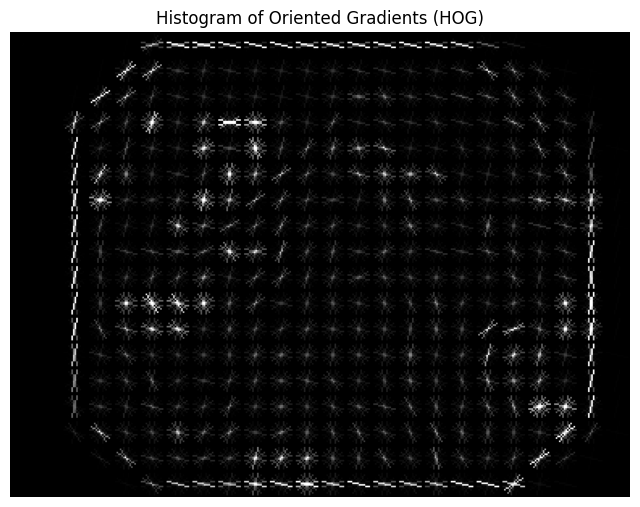

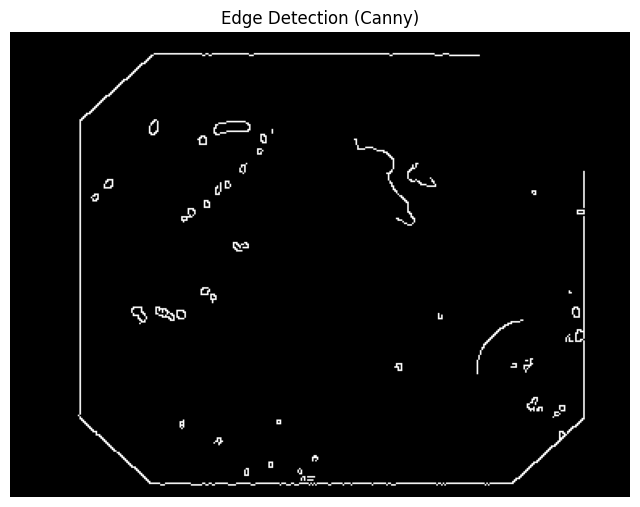

In [63]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from skimage.feature import hog
from skimage import exposure

# Assuming you have a pretrained model (for CAM visualization)
# model = ... # Load your model here

# Path to a sample image
sample_image_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Original/66.png"

# Load the image
img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 1. **Class Activation Map (CAM) Visualization**
def generate_cam(model, img_tensor, target_class):
    model.eval()
    features_blobs = []

    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())

    # Attach hook to the final convolutional layer
    final_conv_layer = model._modules.get('layer4')
    final_conv_layer.register_forward_hook(hook_feature)

    # Forward pass through the model
    output = model(img_tensor)
    pred_probabilities = F.softmax(output, dim=1).data.squeeze()
    class_idx = target_class  # Assuming target_class is provided

    # Get the weights of the linear layer
    weight_softmax = model._modules.get('fc').weight.data.cpu().numpy()

    # Generate CAM
    cam = weight_softmax[class_idx].dot(features_blobs[0].reshape((512, -1)))
    cam = cam.reshape(features_blobs[0].shape[2], features_blobs[0].shape[3])
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]))
    cam = np.uint8(255 * cam)
    cam_heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    return cam_heatmap

# Assuming you have the image tensor
# img_tensor = ...  # Your code to get the image tensor
# cam_heatmap = generate_cam(model, img_tensor, target_class=0)

# Overlay CAM on the image
# result = cam_heatmap * 0.4 + img_rgb
# plt.imshow(result)
# plt.axis('off')
# plt.title("Class Activation Map")
# plt.show()

# 2. **Histogram of Oriented Gradients (HOG) Visualization**
def visualize_hog(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    plt.figure(figsize=(8, 8))
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title("Histogram of Oriented Gradients (HOG)")
    plt.axis('off')
    plt.show()

# Visualize HOG for the sample image
visualize_hog(img_rgb)

# 3. **Edge Detection Visualization**
def visualize_edges(image):
    edges = cv2.Canny(image, 100, 200)

    plt.figure(figsize=(8, 8))
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection (Canny)")
    plt.axis('off')
    plt.show()

# Visualize edges for the sample image
visualize_edges(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))


In [ ]:
def display_random_samples(image_paths, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(3, 3, i+1)
        img = Image.open(random.choice(image_paths))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Assuming your images are stored in a directory
image_paths = glob(os.path.join(image_path, f"*{extn}"))
display_random_samples(image_paths)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Path to your images
image_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Original"

# Load image paths
image_paths = glob.glob(f"{image_path}/*")

# Check the number of images
num_images = len(image_paths)
print(f"Found {num_images} images in the directory.")

# If there are no images
if num_images == 0:
    print("No images found in the directory.")

# If there is only one image
elif num_images == 1:
    print("Only one image found. PCA and t-SNE require more samples.")

    # Display the single image
    img = Image.open(image_paths[0])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# If there are a few images, but not enough for PCA or t-SNE
elif num_images > 1 and num_images < 5:
    print(f"Only {num_images} images found. Displaying them.")

    # Display all images
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, num_images, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# If there are enough images, attempt PCA and t-SNE
else:
    print(f"Found {num_images} images. Proceeding with PCA and t-SNE.")

    # Flatten images for PCA and t-SNE
    X = [np.array(Image.open(img_path)).flatten() for img_path in image_paths]

    # PCA Visualization
    if len(X) > 1 and len(X[0]) > 1:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[0]*len(X_pca))  # Replace [0]*len(X_pca) with actual labels if available
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.title('PCA of Image Dataset')
        plt.show()
    else:
        print("PCA cannot be applied because there are not enough samples or features.")

    # t-SNE Visualization
    if len(X) > 1:
        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(X)

        plt.figure(figsize=(8, 6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[0]*len(X_tsne))  # Replace [0]*len(X_tsne) with actual labels if available
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.title('t-SNE of Image Dataset')
        plt.show()
    else:
        print("t-SNE cannot be applied because there are not enough samples.")


## Load the test image

In [35]:
test_img = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Original/10.png"
# I take the image for training
image = image_loader(test_img)

# Convert the image to a batch of 1 image
image = np.expand_dims(image,0)

# Convert numpy array to torch tensor
image = torch.from_numpy(image)

In [24]:
# Port the image to GPU if it is available
if torch.cuda.is_available():
    image = image.to(device="cuda")

[link text](https://)## Make prediction

In [25]:
mask = model(image)
#genereted image

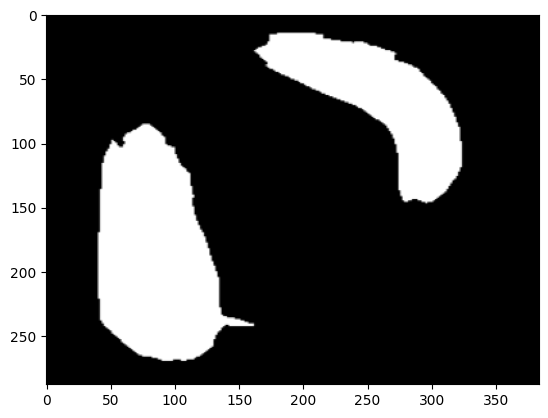

In [26]:
# here i get result of image after training data
mask = mask[-1]

# Convert torch tensor to numpy array
mask = mask.detach().cpu().numpy()

# Convert output to a 2-d array
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)

# Convert output to binary based on threshold
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0

# Resize the ouptut image to input image size
mask = cv2.resize(mask, (im_width, im_height))

# Plot the generated mask
plt.imshow(mask, cmap="gray")

## Read and plot the ground truth mask

> Add blockquote



1.   List item
2.   List item



*   List item
*   List item



---



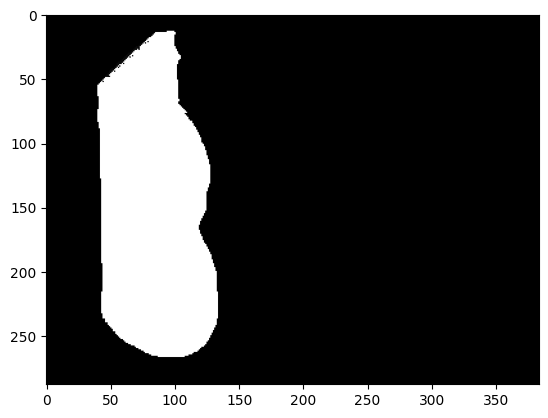

In [27]:
actual_mask = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Ground Truth/10.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")
#I should get result like this above(actuel result)